In [1]:
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
import gc

# **Logistic regression**

In [2]:
# Out-of-fold prediction files are saved in folder 'Out-of-fold predictions'
paths = ['oof_lgbm_baseline_5fold_seed42_l2_5_1258fe_round2_9500_new.csv'
        ,'oof_lgbm_baseline_5fold_seed42_l2_5_1258fe_round2_9500_ff25.csv'
        ,'oof_xgb_v0_5fold_seed42_fea1285_round2.csv'
        ,'oof_xgb_0796_kaggle.csv'
        ]

In [3]:
# Create dataframe
oof_df = pd.DataFrame()

for i, path in enumerate(paths):
    
    # Find filename
    start = 0
    end = path.find('.csv')
    fname = path[start:end]
    
    print(f'model {i+1} is: {fname}')
    
    temp = pd.read_csv(path)
    
    # Set column name of oof
    temp.rename(columns={'prediction': f'model {i+1}'}, inplace=True)
    
    # Drop redundant target column
    if i != 0:
        temp.drop(columns=['target'], inplace=True)
    
    # Join to main file
    if i == 0:
        oof_df = temp
    else:
        oof_df = pd.merge(oof_df, temp, on="customer_ID", how="left")
    
oof_df.shape

model 1 is: oof_lgbm_baseline_5fold_seed42_l2_5_1258fe_round2_9500_new
model 2 is: oof_lgbm_baseline_5fold_seed42_l2_5_1258fe_round2_9500_ff25
model 3 is: oof_xgb_v0_5fold_seed42_fea1285_round2
model 4 is: oof_xgb_0796_kaggle


(458913, 6)

In [4]:
# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)


# https://www.kaggle.com/kyakovlev
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/327534
def amex_metric(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

In [5]:
# Compute CV scores of each out-of-fold predictions
oofCols = [col for col in oof_df.columns if 'oof' in col]

for col in oofCols:
    metric = amex_metric_mod(oof_df['target'], oof_df[col])
    
    print(f"{col} : {metric}")

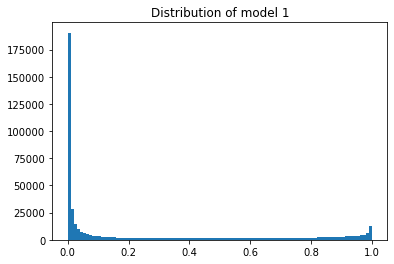

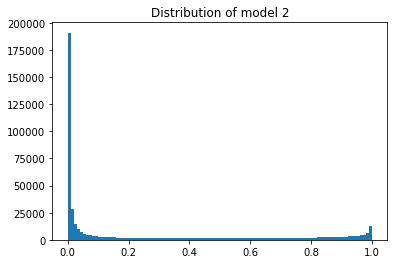

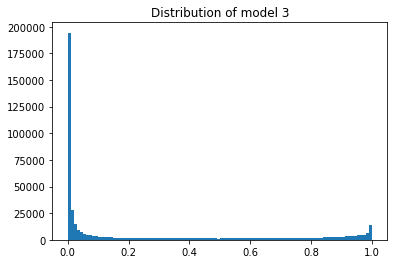

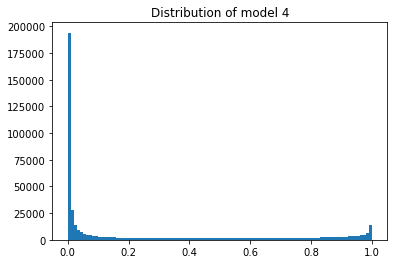

In [6]:
# Plot distributions of each out-of-fold predictions
features = [col for col in oof_df.columns if col not in ['customer_ID', 'target']]
for fe in features:
    plt.hist(oof_df[fe], bins=100)
    plt.title(f'Distribution of {fe}')
    plt.show()

In [7]:
# Stacking 
train = oof_df
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_final = np.zeros(len(train))
for fold, (trn_idx, val_idx) in enumerate(kfold.split(train[features], train['target'])):
    print('')
    print('-'*50)
    print(f'Trainig fold {fold}')
    x_train, x_val = train[features].iloc[trn_idx], train[features].iloc[val_idx]
    y_train, y_val = train['target'].iloc[trn_idx], train['target'].iloc[val_idx]
    logreg = LogisticRegression(random_state=16)
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict_proba(x_val)[::,1]
    score = amex_metric(y_val, y_pred)
    print(f'Fold {fold} has score {score}')
    oof_final[val_idx] = y_pred
    del x_train, y_train, x_val, y_val
    gc.collect()
score = amex_metric(train['target'], oof_final)
print(f'Overall score is {score}!')
oof_final_df = pd.DataFrame({'customer_ID':train['customer_ID'], 
                             'target':train['target'], 'oof_final': oof_final})
#oof_final_df.to_csv('logistic_final_oof.csv', index=False)


--------------------------------------------------
Trainig fold 0
Fold 0 has score 0.8044957938555143

--------------------------------------------------
Trainig fold 1
Fold 1 has score 0.796348162054846

--------------------------------------------------
Trainig fold 2
Fold 2 has score 0.7992744469035331

--------------------------------------------------
Trainig fold 3
Fold 3 has score 0.7958367600712971

--------------------------------------------------
Trainig fold 4
Fold 4 has score 0.8008904338659004
Overall score is 0.7993316064706304!


In [8]:
oof_final_df.oof_final.mean(), oof_final_df.oof_final.std()

(0.2589331297849998, 0.35759680658983434)

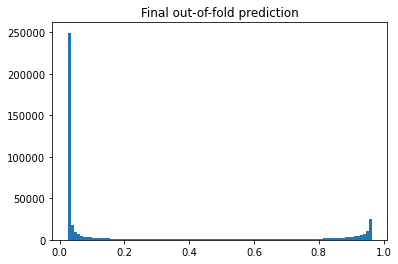

In [9]:
# Plot distribution
plt.hist(oof_final_df.oof_final, bins=100)
plt.title('Final out-of-fold prediction')
plt.show()

# **Submision**

In [10]:
# Single model predictions are saved in folder 'Single model predictions'
test_path = ['test_lgbm_5folds_seed42_l2_5_1258fe_round2_9500_new.csv'
            ,'test_lgbm_5folds_seed42_l2_5_1258fe_round2_9500_ff25.csv'
            ,'XGB_5folds_seed42_fe1285_round2.csv'
            ,'submission_0796_kaggle.csv'
            ]

In [11]:
test_df = pd.DataFrame()

for i, path in enumerate(test_path):
    
    # Find filename
    start = 0
    end = path.find('.csv')
    fname = path[start:end]
    
    print(f'model {i+1} is: {fname}')
    
    temp = pd.read_csv(path)
    
    # Set column name of oof
    temp.rename(columns={'prediction': f'model {i+1}'}, inplace=True)
    
    
    # Join to main file
    if i == 0:
        test_df = temp
    else:
        test_df = pd.merge(test_df, temp, on="customer_ID", how="left")
    
test_df.shape

model 1 is: test_lgbm_5folds_seed42_l2_5_1258fe_round2_9500_new
model 2 is: test_lgbm_5folds_seed42_l2_5_1258fe_round2_9500_ff25
model 3 is: XGB_5folds_seed42_fe1285_round2
model 4 is: submission_0796_kaggle


(924621, 5)

In [12]:
test_df.head()

,customer_ID,model 1,model 2,model 3,model 4
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.024439,0.026165,0.028794,0.253203
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001186,0.001194,0.000856,0.044007
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.034440,0.028388,0.029196,0.287626
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.193151,0.180222,0.207366,0.431190
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.881658,0.877606,0.908114,0.890808


In [13]:
feat = [fe for fe in test_df.columns if fe not in ['customer_ID']]
x_test = test_df[feat]
x_pred = logreg.predict_proba(x_test)[::,1]
test_df['prediction'] = x_pred
submission = test_df[['customer_ID', 'prediction']]
#submission.to_csv('submission_stacking0.csv', index=False)

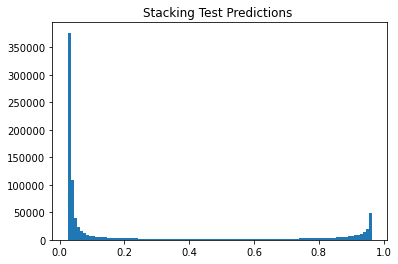

In [14]:
# Plot the distribution of the final submission
plt.hist(submission.prediction, bins=100)
plt.title('Distribution of predictions after stacking')
plt.show()